# Loan Granting Prediction
## Adura ABIONA, PhD (UNSW)
### 12 February, 2017

## Introduction
This project is based on the Cortana Intelligence Gallery Competition . This competition was part of the requirement for Data Science Professional Project for **Microsoft Professional Program in Data Science(MPP-DS)**. The competition started on 12/12/2016 and ended on 1/29/2017. The evaluation criterium to achieve a passing grade in the accompanying course is that **Private Score Highest** has to be at least **70%**. 

### Short Description for the Required Task 
This competition concerns loan data. When a customer applies for a loan, banks and other credit providers use statistical models to determine whether or not to grant the loan based on the likelihood of the loan being repaid. The factors involved in determining this likelihood are complex, and extensive statistical analysis and modelling are required to predict the outcome for each individual case. The task is to implement a model that predicts loan repayment or default based on the data provided.

### Dataset Information
The dataset used in this competition consists of synthetic data that was generated specifically for use in this project. The data is designed to exhibit similar characteristics to genuine loan data. The dataset consisting of over 111,000 loan records to determine the best way to predict whether a loan applicant will fully repay or default on a loan.

More information on it can be found at [**Loan Granting Binary Classification December 2016**](https://gallery.cortanaintelligence.com/Competition/1ad7a6df99794816b9bc071e27d46b10).

In [1]:
import glob, os, string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline 
print(pd.__version__)

import seaborn as sns  # Seaborn, useful for graphics
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
# This Function takes as input a custom palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

0.18.1


In [2]:
dfLoan = pd.read_csv("LoansTrainingDataset.csv")
print(dfLoan.shape)
dfLoan.head(2)

(111107, 19)


c:\users\adura\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Charged Off,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Charged Off,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0


In [3]:
#Check for the number of missing values in each column as isnull() 
dfLoan.apply(lambda x: sum(x.isnull()),axis=0) 

Loan ID                             0
Customer ID                         0
Loan Status                         0
Current Loan Amount                 0
Term                                0
Credit Score                    21338
Years in current job                0
Home Ownership                      0
Annual Income                   21338
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    59003
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 0
Bankruptcies                      228
Tax Liens                          11
dtype: int64

There are **111,107 rows and 19 columns** in this dataset out of which **59,003 rows** more than 50% of the records have missing values in the *Months since last delinquent*" column alone. This is a lot, therefore it will not contribute much information to the modeling as such I will drop this column.

There are still **21,338 rows** that have missing values in the ***Credit Score*** and ***Annual Income*** columns. This is a somewhat significant number which could be treated by repalcing them with mean/median of each  column or by forward/backward filling methods. However, considering this number and the importance of annual income and credit score in the ability of an applicant to pay back the loan, using above methods would affect the modelling result negatively.  Therefore, it is advisable to drop them.

In [4]:
print(dfLoan.shape)
# Removes columns with missing values 
dfLoan1 = dfLoan.drop(labels=['Months since last delinquent'], axis=1)

# Removes rows with missing values    
dfLoan1 = dfLoan1[~pd.isnull(dfLoan1).any(axis=1)]

print(dfLoan1.shape)
dfLoan1.head(2)

(111107, 19)
(89586, 18)


,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Charged Off,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Charged Off,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,14,0,35706,77961,0.0,0.0


In [5]:
## Checking feature types
def coltype(df):
        datatype1 = df.select_dtypes(exclude = ['object']).dtypes
        print('**** Number of numeric features = {} ****'.format(datatype1.count()))
        print(datatype1)
    
        datatype2 = df.select_dtypes(include = ['object']).dtypes
        print('\n**** Number of non-numeric features = {} ****'.format(datatype2.count()))
        print(datatype2)
        
coltype(dfLoan1)

**** Number of numeric features = 9 ****
Current Loan Amount            int64
Credit Score                 float64
Annual Income                float64
Years of Credit History      float64
Number of Open Accounts        int64
Number of Credit Problems      int64
Current Credit Balance         int64
Bankruptcies                 float64
Tax Liens                    float64
dtype: object

**** Number of non-numeric features = 9 ****
Loan ID                 object
Customer ID             object
Loan Status             object
Term                    object
Years in current job    object
Home Ownership          object
Purpose                 object
Monthly Debt            object
Maximum Open Credit     object
dtype: object


In [6]:
# List unique elements of each feature and also detects datatype misclassification 
def uniqueCatList(df):
    print('Frame shape: {}'.format(df.shape))
    for col in df.select_dtypes(include = ['object']).columns.tolist():
        print('\nNumber of unique members[{}] = {}'.format(col,  len(df[col].unique().tolist())))
        print(df[col].unique())
#numeric_feats = train.dtypes[train.dtypes != "object"].index
uniqueCatList(dfLoan1)  

Frame shape: (89586, 18)

Number of unique members[Loan ID] = 72666
['6cf51492-02a2-423e-b93d-676f05b9ad53'
 '552e7ade-4292-4354-9ff9-c48031697d72'
 '9b5e32b3-8d76-4801-afc8-d729d5a2e6b9' ...,
 '503f01e2-c3c4-4b10-886e-f15de57b6f1a'
 '8af53bc0-56a4-4801-a960-52a46a90b33f'
 'f83ae0e1-bd30-46c7-9f72-f4f9fe2f36ca']

Number of unique members[Customer ID] = 72666
['7c202b37-2add-44e8-9aea-d5b119aea935'
 'e7217b0a-07ac-47dd-b379-577b5a35b7c6'
 '0a62fc41-16c8-40b5-92ff-9e4b763ce714' ...,
 '27a17610-1d8c-48a7-b0db-2d81a4fa099a'
 'c124ca71-f42a-47cc-8ec2-236f7e9868a5'
 '74187e35-39c2-4010-ae0d-8bcd0544189e']

Number of unique members[Loan Status] = 2
['Charged Off' 'Fully Paid']

Number of unique members[Term] = 2
['Short Term' 'Long Term']

Number of unique members[Years in current job] = 12
['< 1 year' '10+ years' '9 years' '3 years' '2 years' '7 years' '6 years'
 '1 year' '5 years' '4 years' '8 years' 'n/a']

Number of unique members[Home Ownership] = 4
['Rent' 'Home Mortgage' 'Own Home' 'Ha

In [7]:
dfLoan1.groupby('Years in current job')['Loan ID'].nunique()

Years in current job
1 year        4676
10+ years    22573
2 years       6681
3 years       5987
4 years       4419
5 years       4961
6 years       4153
7 years       4034
8 years       3349
9 years       2820
< 1 year      5911
n/a           3102
Name: Loan ID, dtype: int64

In [8]:
print(dfLoan1.shape)
dfLoan1 = dfLoan1[dfLoan1['Years in current job'] != 'n/a']
print(dfLoan1.shape)

(89586, 18)
(85799, 18)


With the above function, we are able to detect that ***Monthly Debt*** and ***Maximum Open Credit*** faetures are numeric but have some elements that are wrongly input as string.

In [9]:
# List non-numeric elements in numeric features
def DetectNonNumeric(dfx, nnCol):
    for colx in nnCol:
        nonNumList = []
        for el in dfx[colx].unique().tolist():
            try:      
                float(el)
            except:
                nonNumList.append(el)
        print('{}: {}'.format(colx, nonNumList))
        
DetectNonNumeric(dfLoan1, ['Monthly Debt','Maximum Open Credit'])  

Monthly Debt: ['$1051.41', '$157.15', '$944.7', '$481.34', '$1838.98', '$471.6']
Maximum Open Credit: ['#VALUE!']


The code block below munges the ***Monthly Debt*** and ***Maximum Open Credit*** columns to the correct format

In [10]:
# coverting feature element  to numeric and forcing string to nan
dfLoan1['Monthly Debt'] = [float(str(row).replace("$",""))  if '$' in str(row) else row   for row in dfLoan1['Monthly Debt']]
dfLoan1['Monthly Debt'] = pd.to_numeric(dfLoan1['Monthly Debt'], errors='coerce')

dfLoan1['Maximum Open Credit'] = pd.to_numeric(dfLoan1['Maximum Open Credit'], errors='coerce')
dfLoan1['Maximum Open Credit'].fillna(dfLoan1['Maximum Open Credit'].mean(), inplace=True) # fill missing values with mean

DetectNonNumeric(dfLoan1, ['Monthly Debt','Maximum Open Credit']) 

Monthly Debt: []
Maximum Open Credit: []


In [11]:
# Removing duplicate rows
print(dfLoan1.shape)
dfLoan1.drop_duplicates(['Loan ID'], inplace = True) 
print(dfLoan1.shape)

(85799, 18)
(69564, 18)


In [12]:
dfLoan1.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,6.956400e+04,69564.000000,6.956400e+04,69564.000000,69564.000000,69564.000000,69564.000000,6.956400e+04,6.956400e+04,69564.000000,69564.000000
mean,1.759554e+07,1158.479961,7.349708e+04,978.994946,18.079383,11.182106,0.157294,1.558985e+04,3.470192e+04,0.109784,0.027931
std,3.806309e+07,1616.089117,5.843198e+04,643.432555,6.817144,5.001756,0.471899,1.999984e+04,3.371763e+05,0.339558,0.259343
min,7.010000e+02,585.000000,4.033000e+03,0.000000,3.700000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.958750e+03,711.000000,4.536000e+04,547.317500,13.500000,8.000000,0.000000,6.041750e+03,1.278275e+04,0.000000,0.000000
50%,1.503000e+04,731.000000,6.312400e+04,858.570000,16.900000,10.000000,0.000000,1.119500e+04,2.181100e+04,0.000000,0.000000
75%,2.759700e+04,743.000000,8.812500e+04,1267.422500,21.500000,14.000000,0.000000,1.950225e+04,3.636700e+04,0.000000,0.000000
max,1.000000e+08,7510.000000,8.713547e+06,22939.120000,70.500000,76.000000,15.000000,1.730472e+06,6.998809e+07,7.000000,15.000000


In [13]:
# Getting the categorical features
datacols = dfLoan1.select_dtypes(exclude = ['object']).columns.tolist()
print(datacols)
len(datacols)

['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens']


11

#### The code block below comprises data visualization to deal with outliers.

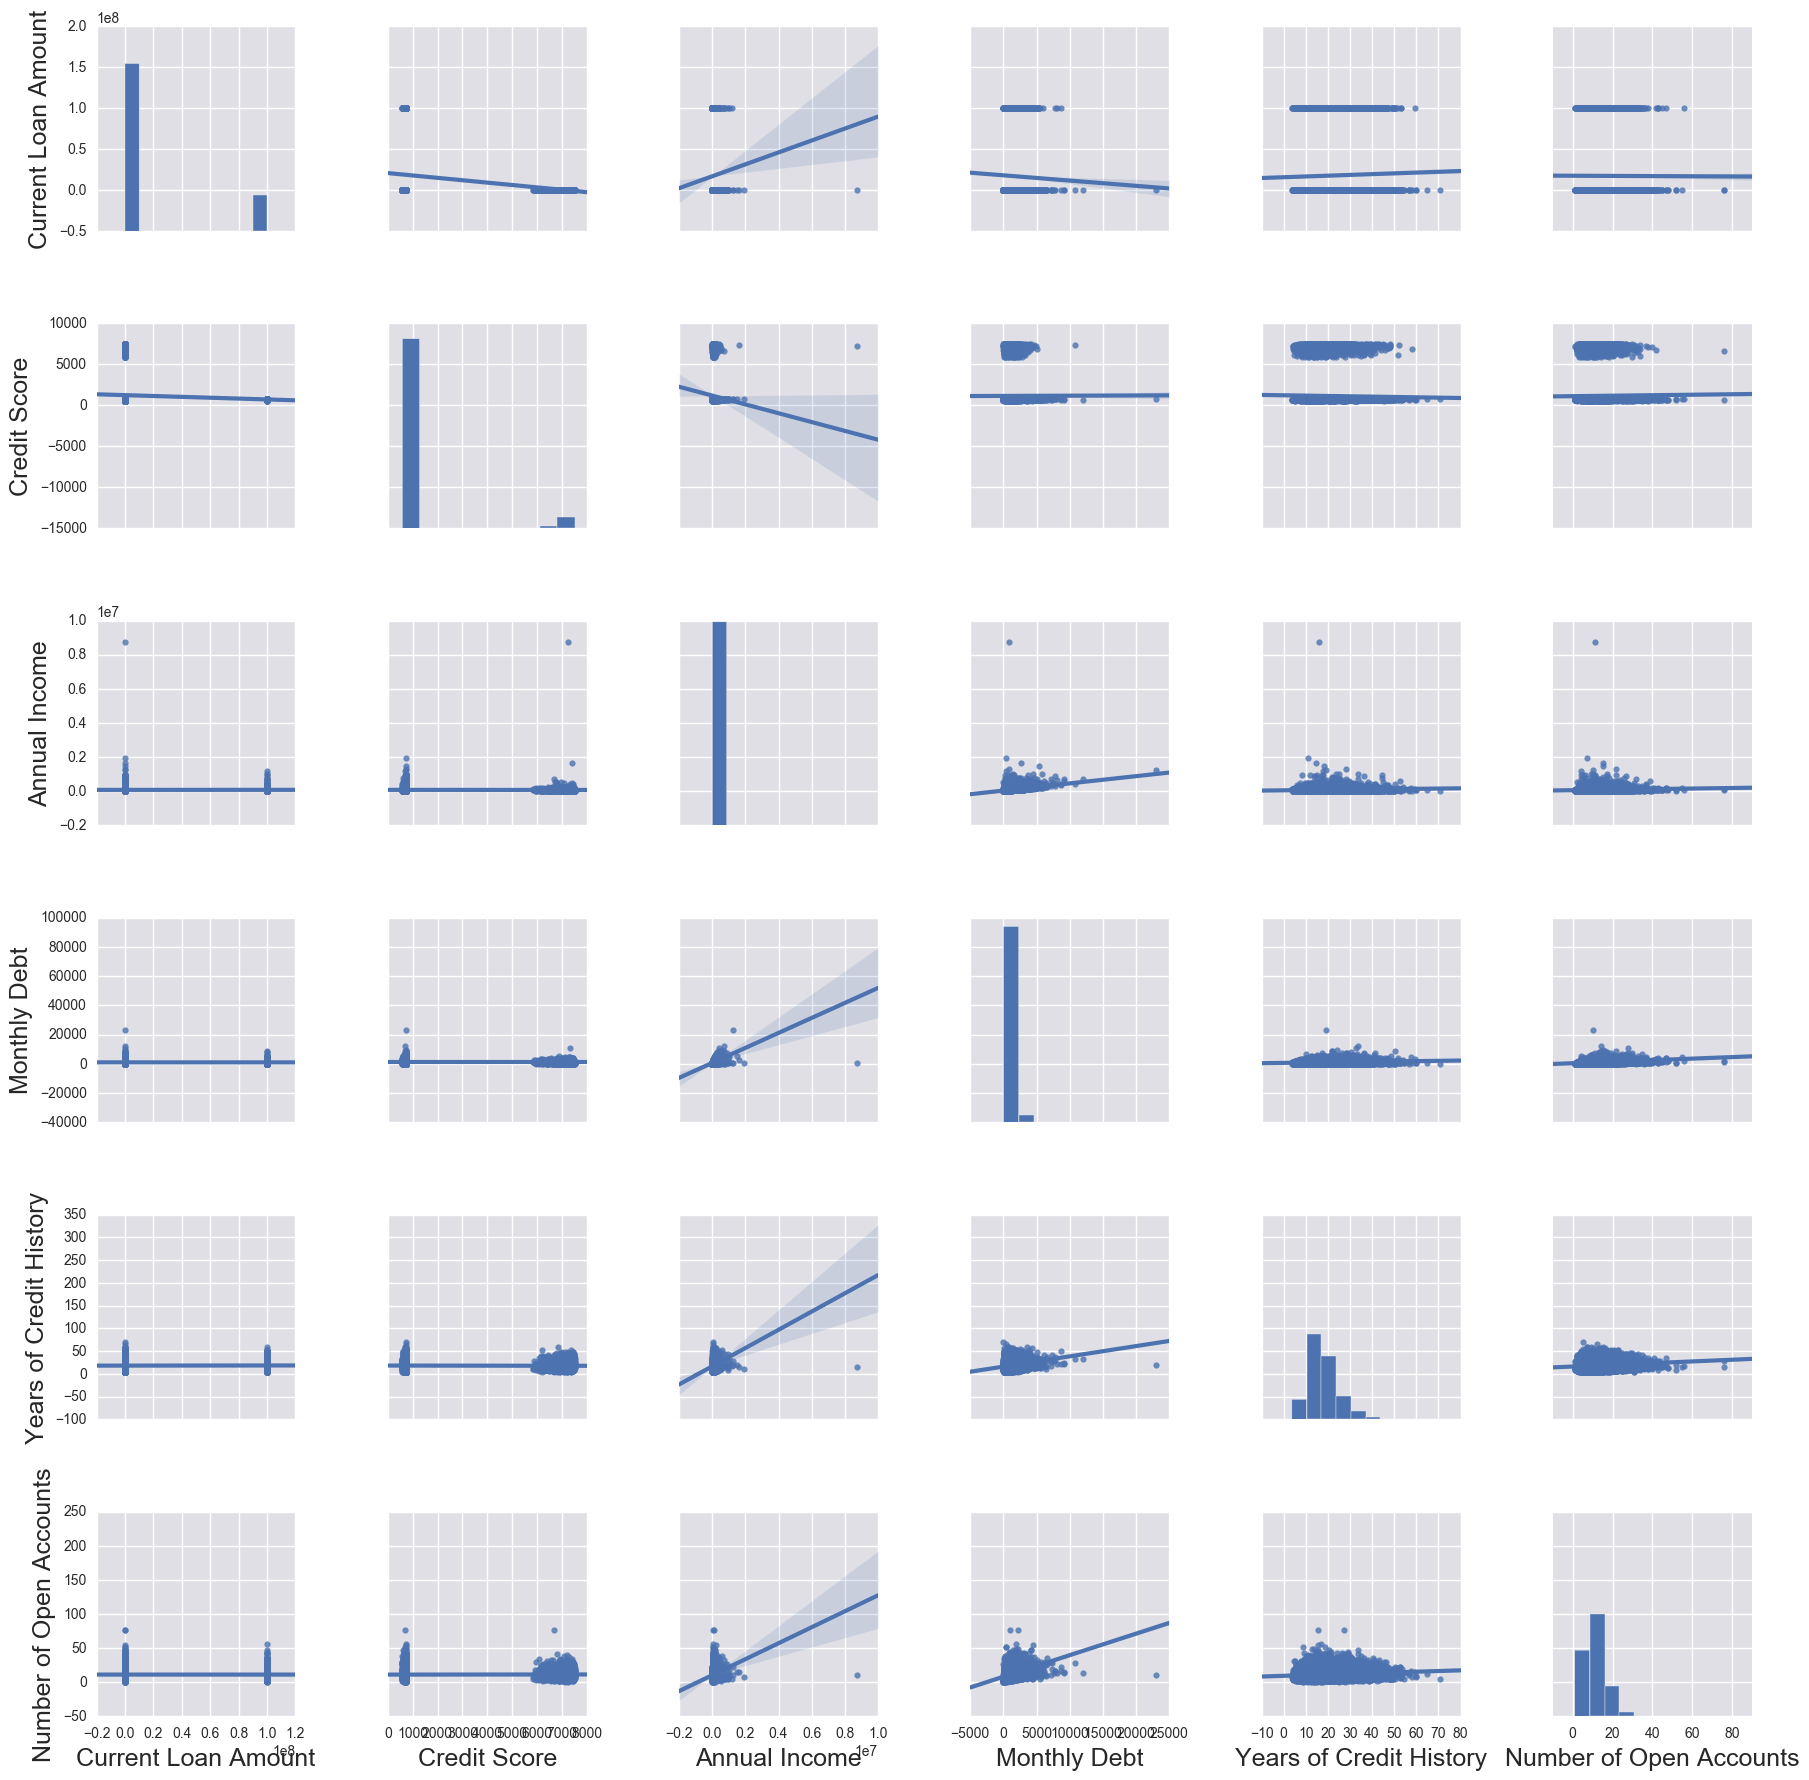

In [14]:
datacol1 = ['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 
            'Years of Credit History', 'Number of Open Accounts']
sns.pairplot(dfLoan1, vars=datacol1, size=3, kind="reg") #size=3, diag_kind="kde", kind="reg")

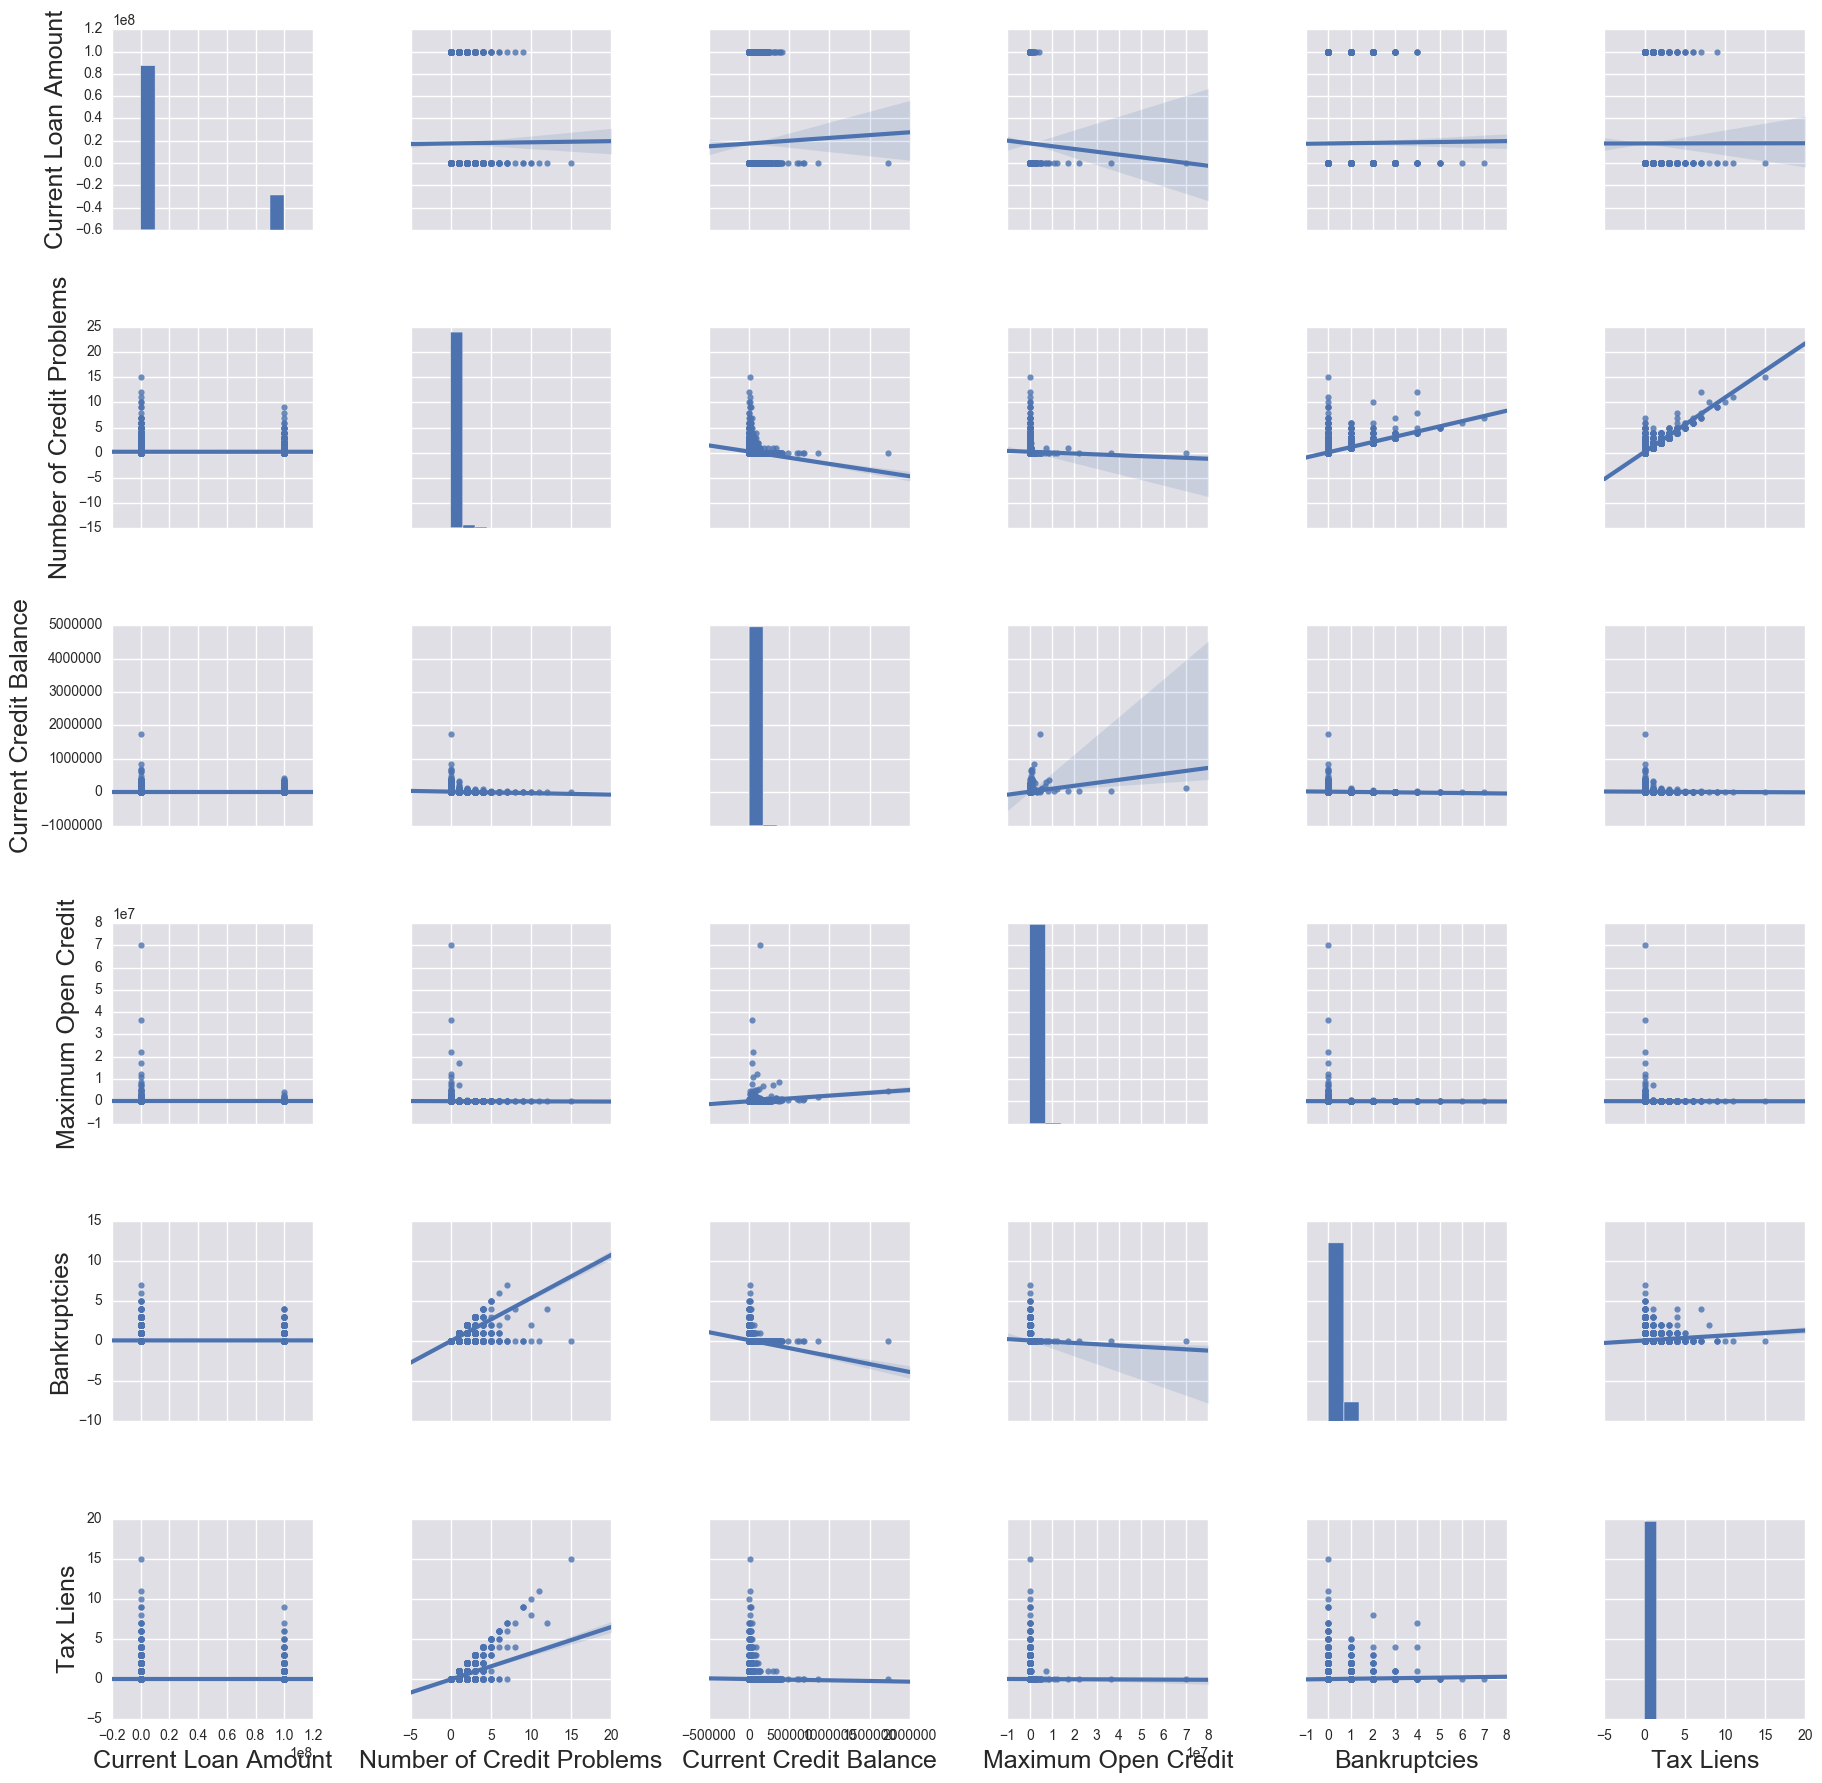

In [15]:
datacol2 = ['Current Loan Amount', 'Number of Credit Problems', 'Current Credit Balance', 
            'Maximum Open Credit', 'Bankruptcies', 'Tax Liens']
sns.pairplot(dfLoan1, vars=datacol2, size=3, kind="reg") #size=3, diag_kind="kde", kind="reg")

In [16]:
# 'Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts'
def plot_outlier(x,y):
    fig,axs=plt.subplots(1,2,figsize=(8,3))
    sns.boxplot(y,orient='v',ax=axs[0])
    sns.regplot(x,y,ax=axs[1])
    plt.tight_layout()

In [17]:
dfx0 = dfLoan1[dfLoan1['Current Loan Amount'] <  0]
print(dfx0.shape)
dfx1 = dfLoan1[dfLoan1['Current Loan Amount'] <  0.5E8]
print(dfx1.shape)
dfx2 = dfLoan1[dfLoan1['Current Loan Amount'] >  0.5E8]
dfx2.shape

(0, 18)
(57332, 18)


(12232, 18)

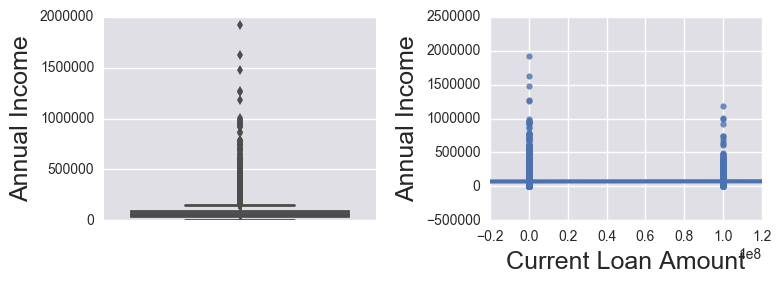

In [18]:
dfLoan1 = dfLoan1[dfLoan1['Annual Income'] <  0.2E7]
plot_outlier(dfLoan1['Current Loan Amount'], dfLoan1['Annual Income'])

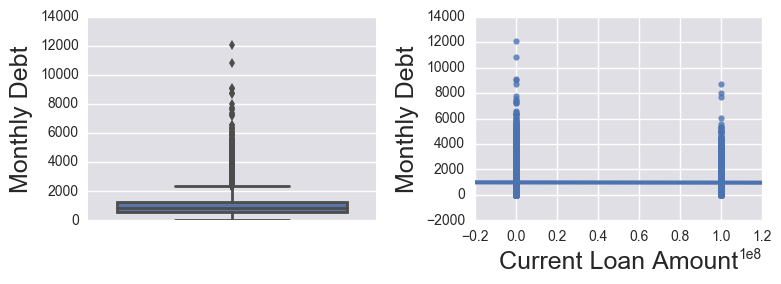

In [19]:
dfLoan1 = dfLoan1[dfLoan1['Monthly Debt'] <  15000]

plot_outlier(dfLoan1['Current Loan Amount'], dfLoan1['Monthly Debt'])

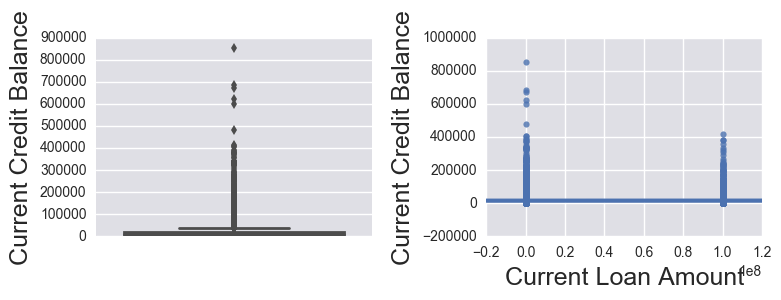

In [20]:
dfLoan1 = dfLoan1[dfLoan1['Current Credit Balance'] <  1000000]

plot_outlier(dfLoan1['Current Loan Amount'], dfLoan1['Current Credit Balance'])

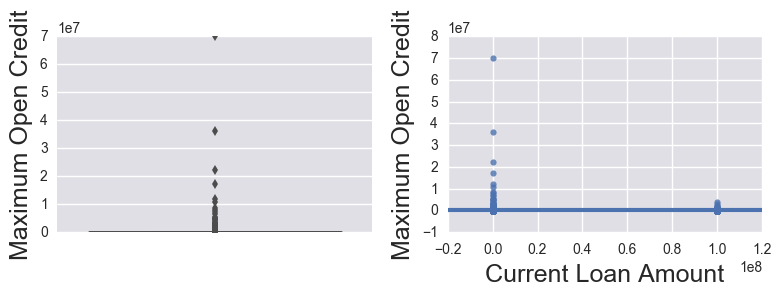

In [21]:
dfLoan1 = dfLoan1[dfLoan1['Annual Income'] <  3.0E7]

plot_outlier(dfLoan1['Current Loan Amount'], dfLoan1['Maximum Open Credit'])

In [22]:
dfLoan1.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,6.956100e+04,69561.000000,6.956100e+04,69561.000000,69561.000000,69561.000000,69561.000000,69561.000000,6.956100e+04,69561.000000,69561.000000
mean,1.759630e+07,1158.309929,7.335114e+04,978.540201,18.079189,11.181884,0.157301,15564.709104,3.463769e+04,0.109789,0.027932
std,3.806374e+07,1615.789224,4.816049e+04,636.941330,6.817066,5.001456,0.471908,18913.401906,3.367615e+05,0.339564,0.259349
min,7.010000e+02,585.000000,4.033000e+03,0.000000,3.700000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,8.959000e+03,711.000000,4.536000e+04,547.310000,13.500000,8.000000,0.000000,6041.000000,1.278200e+04,0.000000,0.000000
50%,1.503000e+04,731.000000,6.312200e+04,858.540000,16.900000,10.000000,0.000000,11195.000000,2.181000e+04,0.000000,0.000000
75%,2.759700e+04,743.000000,8.811600e+04,1267.400000,21.500000,14.000000,0.000000,19499.000000,3.636700e+04,0.000000,0.000000
max,1.000000e+08,7510.000000,1.919760e+06,12055.680000,70.500000,76.000000,15.000000,854602.000000,6.998809e+07,7.000000,15.000000


## Model prediction
For the model prediction, I will be using a classifier of gradient boosted decision trees to predict whether a loan applicant will fully repay or default on a loan. In particular, I will use XGBoost. It is an algorithm that has recently been dominating applied machine learning and [**Kaggle competitions**](https://www.kaggle.com/competitions) for structured data.

[**XGBoost**](http://xgboost.readthedocs.io/en/latest/model.html) is an implementation of gradient boosted decision trees designed for speed and performance. [**Szilard Pafka's excellent benchmark**](https://github.com/szilard/benchm-ml) of a variety of machine learning libraries attest to XGBoost fast computation speed.

In [23]:
#import model libraries
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler 
import scipy.stats as st
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
#Import evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score,  roc_curve, auc, precision_score, recall_score
import itertools

## Applying Ordinal Encoding to Categoricals
We need to convert some features into categorical group to make processing simpler. The columns Vessel_ID represents categorical feature. However, because it is an integer, it is initially parsed as continuous number. It is also required to encode features like DayNight with a string category since XGBoost (like all of the other machine learning algorithms in Python) requires every feature vector to include only digits. 

In [24]:
# categorizing features that need it
CategLx = ['Loan Status', 'Term', 'Years in current job', 'Home Ownership', 'Purpose'] # Categorical features 
dfLoan2 = dfLoan1.copy() 
for fea in dfLoan2[CategLx]: # Loop through all columns in the dataframe
    dfLoan2[fea] = pd.Categorical(dfLoan2[fea]).codes # Convert to categorical features

In [25]:
#Separate target from other features: input (X) features, target (y) feature & label (Z) feature
#Z = dfLoan1['Loan ID']
Y = dfLoan2['Loan Status']
X = dfLoan2.drop(['Loan Status', 'Loan ID', 'Customer ID'], axis=1)

In [26]:
#Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.45, random_state=123)

#### Next step is to separate features into numeric/categorical groups to make scaling  which is needed for accurate prediction for numeric features. 

In [27]:
CategLs = ['Term', 'Years in current job', 'Home Ownership', 'Purpose'] # Categorical features 
X_train_Cat = X_train[CategLs]
X_test_Cat = X_test[CategLs]

X_train_Num = X_train.drop(CategLs, axis=1)
X_test_Num = X_test.drop(CategLs, axis=1)

In [28]:
scaler = StandardScaler() # create scaler object
scaler.fit(X_train_Num) # fit with the training data ONLY
X_train_Num = scaler.transform(X_train_Num) 
X_test_Num = scaler.transform(X_test_Num) 

In [29]:
# names = datacols
X_train_tot = pd.concat([pd.DataFrame(X_train_Num, columns = datacols), X_train_Cat.reset_index(drop=True)], axis=1)
X_test_tot = pd.concat([pd.DataFrame(X_test_Num, columns = datacols), X_test_Cat.reset_index(drop=True)], axis=1)
print(X_train_Num.shape)
print(X_train_tot.shape)
X_train_tot.head()

(38258, 11)
(38258, 15)


,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Term,Years in current job,Home Ownership,Purpose
0,-0.462301,-0.257638,1.005973,-0.151124,0.104202,-0.038861,-0.33482,-0.171107,-0.067088,-0.322462,-0.106608,1,1,1,3
1,2.163051,-0.265635,-0.884432,-0.734222,-0.730403,-0.637871,-0.33482,-0.439672,-0.102631,-0.322462,-0.106608,1,2,3,3
2,2.163051,-0.273632,-0.606158,-0.472860,-1.682146,-0.637871,-0.33482,-0.691920,-0.024065,-0.322462,-0.106608,1,5,3,3
3,-0.462283,-0.276092,0.386058,0.230215,-0.115431,-0.438201,-0.33482,0.458558,-0.029124,-0.322462,-0.106608,0,1,1,3
4,-0.462608,-0.261944,-0.783780,-1.113740,-0.393632,-1.037211,-0.33482,-0.174154,-0.013185,-0.322462,-0.106608,1,4,3,7


In [30]:
def plotcorrFloat(df, lsFea):
    corr = df[lsFea].corr()
    colormap = plt.cm.viridis
    plt.figure(figsize=(12, 12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    return sns.heatmap(corr, vmax=1, square=True, linewidths=0.1, cmap=colormap, linecolor='white', annot=True)

# Compute ROC curve and ROC area for each class
def plot_ROCcurve(Ytest, pred, title = "ROC Curve"):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(Ytest, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    return plt.show()

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap="jet", savefilename=''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #cmap=plt.cm.Blues
    fmt = "%.0f"
    print('Non-normalized Confusion matrix')
    print(cm)
    
    nfmt = "%.3f"
    ncm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix(scale:0-1)")
    print(ncm)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #plt.imshow(ncm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    
    plt.title(title) 
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) 
    plt.yticks(tick_marks, classes, rotation=90)
    plt.grid(b=False) #plt.tick_params(colors='r') 
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txValue = str(fmt % cm[i, j]) + "[" + str(nfmt % ncm[i, j]) + "]"
        plt.text(j, i, txValue, ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted') 
    
    if savefilename:
        plt.savefig(savefilename, bbox_inches='tight')
        
    return plt.show()

## Hyperparameter Optimization
Randomized search is used instaed of grid search for hyperparameter tuning  because of its speed.

In [31]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

param = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive
}

def Model(xTrain, yTrain, xTest, yTest, params, class_names):
    xgbreg = XGBClassifier(nthread=-1)
    rsCV = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
    rsCV.fit(xTrain, yTrain)
    #rsCV.best_params_, rsCV.best_score_

    clf = XGBClassifier(**rsCV.best_params_)
    clf.fit(xTrain, yTrain)
    predXtest = clf.predict(xTest)
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(yTest, predXtest))
    print ("AUC Score (Train): %f" % roc_auc_score(yTest, predXtest))
    print()
    
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(confusion_matrix(predXtest, yTest), classes=class_names, title='Confusion matrix[normalized]')


Model Report
Accuracy : 0.8098
AUC Score (Train): 0.640319

Non-normalized Confusion matrix
[[ 2341   196]
 [ 5757 23009]]
Normalized confusion matrix(scale:0-1)
[[ 0.9227434  0.0772566]
 [ 0.2001321  0.7998679]]


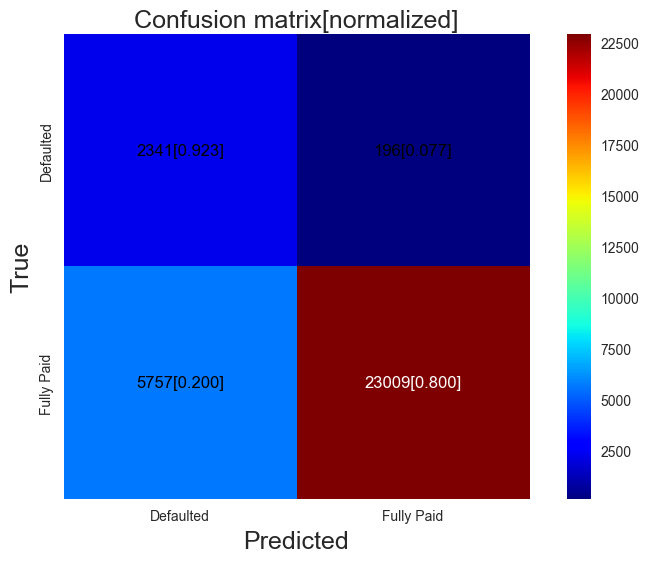

In [32]:
class_names = ['Defaulted', 'Fully Paid']
Model(X_train_tot, Y_train, X_test_tot,  Y_test, param, class_names)

## Conclusion
The model classification accuracy is about 81%. This looks good but for an imbalance data (about only 8% defaulted customer) like this, we need a better evaluation method. 

In this analysis, the null hypothesisthe is to determine if a customer would default. Therefore, the bank would be more interested in protecting its investment so **recall** would be an appropriate evaluation method. From the confusion matrix, the **recall** is **92%.** This prediction is very accurate for this case. 